In [1]:
CODE_PATH = '.' #usually add this folder to path
DATA_PATH = 'E:\\test\\recording' #path with the parsed channels
OUTPUT_FOLDER = 'E:\\test\\recordings_output'
WAVE_CLUS_PATH = 'D:\\GitHub\\wave_clus'
%cd $DATA_PATH

E:\test\recording


### Notes
- When a preprocessing function is applied to a recording like: ```filtered_recording = sp.bandpass_filter(recording)```. *filtered_recording* is not fully calculated, and it will be calculated only when it is required. 
- The custom codes here try to be as compatible as possible with spikeinterface.
- You can see more info about the function running its name with a '?' in a cell like: ```sp.bandpass_filter?```

#### Folder Structure

Example for recording with just channel 55
<pre>
📦OUTPUT_FOLDER
 ┣ 📂raw_recording              #temporary folder with the filtered recording.
 ┣ 📂sortings
 ┃ ┗ 📂55
 ┃    ┗ 📂waveclus
 ┃       ┗ 📂sorter_output
 ┃          ┣ 📜times_results.mat  #sorting result.
 ┃          ┗ 📜spikeinterface_recording.json  #it describes the filtering for that channel.
 ┣ 📂wf_ch_55
 ┃ ┗ 📂quality_metrics
 ┃    ┗ 📜metrics.csv           #metrics.
 ┗ 📂figures
    ┣ 📜unit_ch55_0.png             #figure showing units waveforms and ISIs.
    ┗ 📜unit_ch55_1.png             #figure showing more units waveforms and ISIs.
</pre>

In [3]:
# (not needed for this pipeline) this cell is usefull for edit a library and automatically load the updated library
# It could affect performance 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from sys import path
path.insert(0, CODE_PATH) # adds code folder to path
from custom_recording_extractors import NSXRecordingExtractor
from aux_functions import same_probe_collisions, create_waveform_extractors_by_channel, \
    plot_sorting_results, load_waveforms_extractors 
import numpy as np
from pathlib import Path
from shutil import rmtree
import os
import spikeinterface as si
import preprocessing_functions as pf
import spikeinterface.preprocessing as sp
import spikeinterface.sorters as ss
import spikeinterface.extractors as se
import spikeinterface.widgets as sw
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120 #better matplotlib in jupyter
mpl.rcParams['font.size'] = 10 #better matplotlib in jupyter
ss.WaveClusSorter.set_waveclus_path(WAVE_CLUS_PATH)

Setting WAVECLUS_PATH environment variable for subprocess calls to: D:\GitHub\wave_clus


**From here you can go to [Quality Metrics](#Quality_Metrics) if the sorting is already calculated**

In [29]:
#This load the recording with a vector of channels as the input
# remember that range function in python do not include the right border
# np.concatenate([np.arange(3,9),np.arange(99,104)])  includes channes 3,4,5,6,7,8 and 99,100,101,102,103
channels = [2042,2033]
recording = NSXRecordingExtractor(channels=channels, folder_path=DATA_PATH)

##### Save notes

Use the save method to save the current raw data to a folder. The computed recordings and all the steps to generate them will be saved on that folder. Using load to not recompute evething from the beginning. 

In [ ]:
#(not needed for this pipeline) run this cell to write the raw recording 
precompute_folder = Path(OUTPUT_FOLDER)/'raw_recording'
recording.save(folder=precompute_folder)

In [24]:
#(not needed for this pipeline) run this cell to load the raw recording 
loaded_recording = si.load_extractor(precompute_folder)

***
### Notch Filter

The following cell create and save recording_notched that removes peaks in the spectrum using the calculated notches previusly saved in pre_processing_info.mat. This change could improve the mountainlab pipeline.

In [31]:
#apply calculed notches
recording_notched = pf.filter_freq_peaks(recording, load_mat_notches=True)

***
### Bandpass Filter

In [34]:
recording_filtered = sp.preprocessing.filter.BandpassFilterRecording(recording_notched, freq_min=300, freq_max=3000, filter_order=2)

In [36]:
# (not needed for this pipeline, just an example) run this cell to write the filtered recording 
recording_filtered = recording_filtered.save(folder=Path(OUTPUT_FOLDER)/'filtered_recording')

write_binary_recording with n_jobs = 1 and chunk_size = 30000


write_binary_recording:   0%|          | 0/2111 [00:00<?, ?it/s]

In [6]:
# (not needed for this pipeline, just an example) run this cell to write the filtered recording 
recording_filtered = si.load_extractor(Path(OUTPUT_FOLDER)/'filtered_recording')

***
### Whittening

```sp.whiten(recording, by_property=None)```

In [39]:
# (not needed for this pipeline)
recording_whiten = sp.whiten(recording_filtered) #simil mountainlab pipeline

## Plotting

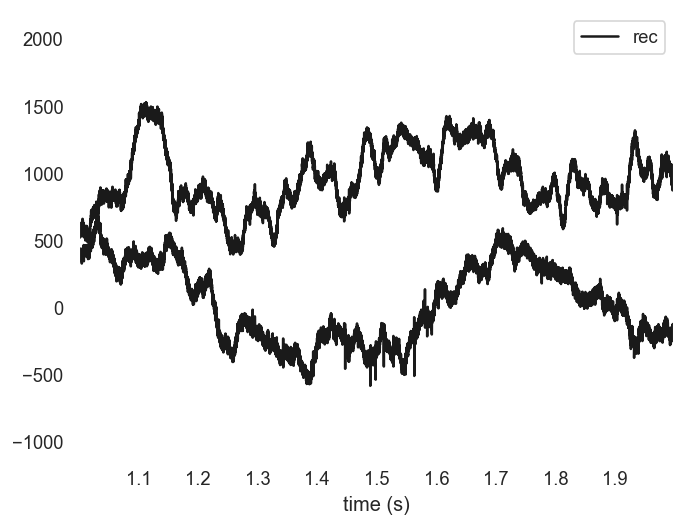

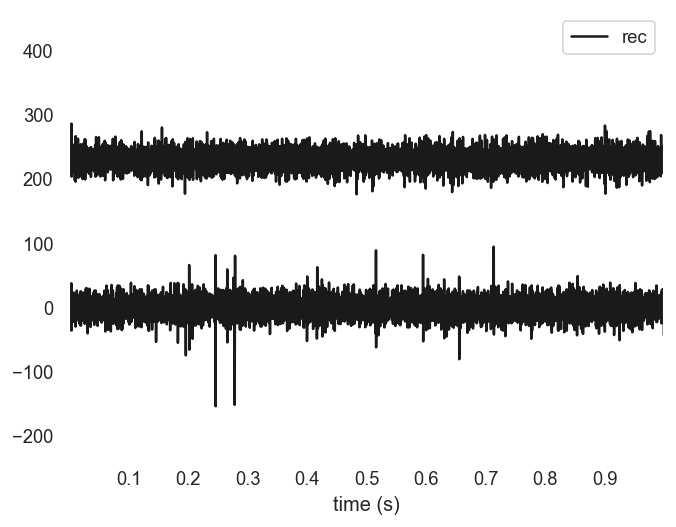

In [42]:
# (not needed, just to show widgets)
# plot first second of raw data and filtered data
sw.plot_timeseries(recording, time_range=(1, 2))
sw.plot_timeseries(recording_filtered, time_range=(0, 1))

### Sorting with Wave_clus

##### Usage
Call sorter:

```ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_filtered, detect_threshold=4.5, detect_sign=-1, enable_detect_filter=False, enable_sort_filter=False, grouping_property='channel', working_folder=OUTPUT_FOLDER,mode_if_folder_exists='overwrite',engine='joblib')```                      

Parameters:

- detect_threshold: threshold to use
- enable_detect_filter: set as False because you don't want to filter the signal again just for detecction.
- enable_sort_filter: set as False because the raw signal is already filtered.
- grouping_property: set as 'channel' to sort each channel independently


In [ ]:
ss.run_sorter_by_property(sorter_name='waveclus',recording=recording_filtered, detect_threshold=4.5, detect_sign=-1, enable_detect_filter=False, enable_sort_filter=False, grouping_property='channel', working_folder=OUTPUT_FOLDER/Path('sortings'),mode_if_folder_exists='overwrite',engine='joblib')
# Then rename auxiliary waveclus files and allow manual curation using temperature plot
# and remove the copy of the filtered recording used by wave_clus
for ch in recording_filtered.get_channel_ids():
    resfolder = OUTPUT_FOLDER/Path('sortings')/Path(str(ch))/Path('waveclus/sorter_output')
    #reducing size and renaming to help waveclus manual curation of results
    os.rename(resfolder/Path('data_raw1.dg_01.lab'),resfolder/Path('data_results.dg_01.lab'))
    os.rename(resfolder/Path('data_raw1.dg_01'),resfolder/Path('data_results.dg_01'))
    os.remove(resfolder/Path('raw1.h5'))

## <a id='Quality_Metrics and Figures'>Quality_Metrics</a>
 
First some waveforms should be extracted from the recording

In [11]:
from spikeinterface.postprocessing import WaveformPrincipalComponent, compute_spike_amplitudes
from spikeinterface.qualitymetrics import compute_quality_metrics, calculate_pc_metrics
from aux_functions import plot_channels_from_wf

for ch,rec in recording_filtered.split_by('channel').items():
    resfolder = OUTPUT_FOLDER/Path('sortings')/Path(str(ch))/Path('waveclus/sorter_output')

    sorting = se.WaveClusSortingExtractor(OUTPUT_FOLDER/Path('sortings')/Path(str(ch))/Path('waveclus/sorter_output/times_results.mat'))
    waveform_folder = OUTPUT_FOLDER/Path(f'wf_ch_{ch}')
    we = si.WaveformExtractor.create(rec, sorting, waveform_folder,remove_if_exists=True)

    we.set_params(ms_before=0.65, ms_after=1.46, max_spikes_per_unit=9999999,return_scaled=True)
    we.run_extract_waveforms(n_jobs=4,chunk_memory='700M',verbose=False)

    pca = WaveformPrincipalComponent(we)
    pca.set_params(n_components=5, mode='by_channel_local')
    pca.run()
    compute_quality_metrics(we)
    calculate_pc_metrics(pca)
    compute_spike_amplitudes(we, peak_sign='neg')
    #plot classic figures, they could show more metrics
    plot_channels_from_wf(OUTPUT_FOLDER/Path(f'wf_ch_{ch}'), OUTPUT_FOLDER/Path('figures'))

e:\programs\Anaconda3\envs\reylab\lib\site-packages\spikeinterface\core\baserecordingsnippets.py:217: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn(


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/3 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/3 [00:00<?, ?it/s]

Computing PCA metrics:   0%|          | 0/3 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/2111 [00:00<?, ?it/s]

e:\programs\Anaconda3\envs\reylab\lib\site-packages\spikeinterface\core\baserecordingsnippets.py:217: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn(


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/8 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/8 [00:00<?, ?it/s]

e:\programs\Anaconda3\envs\reylab\lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:511: UserWarning: Units [6, 7, 8] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and "


Computing PCA metrics:   0%|          | 0/8 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/2111 [00:00<?, ?it/s]

**L-ratio** denotes the amount of contamination of a given cluster and it's calculated as the sum of the probabilities that each spike that is not a cluster member should actually be a part of the cluster divided by the total number of spikes in the cluster. A high value of L-ratio indicates that  the  cluster  is  not  well  separated  and  is  likely  to  include  both spikes that are not part of the cluster and exclude spikes that are part of  the  cluster. 
_Schmitzer-Torbert and Redish. J Neurophy 91.5 (2004): 2259-2272_.